In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Objectives:

We want to look at bandits where the rewards are only 1 or 0 (Bernouilli).

There is one method (Bayesian) that we did not see during the course.
Some explanations there:
https://towardsdatascience.com/thompson-sampling-fc28817eacb8


1) COMPLETE the code where it says "COMPLETE".

2) Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret. 

3) Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  
Play with the c parameter in UCB.

4) Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.

5) What are your conclusions in terms of methods? Give some intution.



In [ ]:
class BernoulliBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions
        if len(p) == 1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [ ]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
    
    def environment(self, env, init_q):
        # initialize environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r 
            
    def act(self):
        # action.
        self.iteration += 1 
        if self.decision_rule == "greedy":
           if self.iteration == 1 :
              selected_action = np.random.choice(self.actions)
           else : 
              selected_action = np.argmax(self.q_estimate)
            
        if self.decision_rule == "epsilon-greedy":
            p = random.random()
            if p < self.epsilon : 
               selected_action = np.random.choice(self.actions)
            else :
               assert self.learning_rule == "averaging" , " Please using averaging learning rule"
               selected_action = np.argmax(self.q_estimate)
               
            
        
        if self.decision_rule == "UCB":
            assert self.learning_rule == "averaging" , " Please using averaging learning rule"
            selected_action = np.argmax(self.q_estimate + self.UCB_param * \
                                        np.sqrt((np.log(self.iteration)/self.act_count)))
            
        if self.decision_rule == "Thompson" :
            assert self.learning_rule == "BayesianBetaPrior" , " Please using Bayesian Beta Prior learning rule"
            samples = [np.random.beta(self.alpha[a],self.beta[a]) for a in self.actions]
            selected_action = np.argmax(samples)
            
        self.act_count[selected_action] += 1
        return selected_action

In [ ]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=1000):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    rewards = np.zeros ((len(agents), repetitions, N))
    bestarm = np.zeros ((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [ ]:
def cumulation(mean_rewards) :
    n_agents , n_iter = mean_rewards.shape
    cumulative_rewards = np.zeros((n_agents,n_iter))
    cumulative_rewards[:,0] = mean_rewards[:,0]
    for k in range(1,n_iter):
       cumulative_rewards[:,k] = mean_rewards[:,k] + cumulative_rewards[:,k-1]
    return cumulative_rewards
def define_agents (tuning  = None) :
    
    agents = []
    configs = []
    if tuning == None : 
        learning_rules = ['averaging','BayesianBetaPrior']
        decision_rules = [['greedy',"epsilon-greedy",'UCB'],['Thompson']]
        for learning_rule,decision_rule_set in zip(learning_rules,decision_rules) : 
            for decision_rule in decision_rule_set :
                if decision_rule =="epsilon-greedy":
                  params = {'epsilon':epsilon}
                elif decision_rule =='UCB' :
                  params = {'UCB_param':UCB_param}
                else :
                  params = [None]
                agent_instance = Agent(learning_rule=learning_rule, decision_rule=decision_rule , param =  params)
                agents.append(agent_instance)
                configs.append(decision_rule)
        return agents , configs

    else :
       assert tuning in ['UCB','epsilon-greedy'] , " We can only tune UCB and epsilon greedy params"
       
       for hyperparameter in hyperparameters :
           if tuning =="epsilon-greedy":
              params = {'epsilon':hyperparameter}
           elif tuning =='UCB' :
              params = {'UCB_param':hyperparameter}
           agent_instance = Agent(learning_rule='averaging', decision_rule=tuning , param =  params)
           agents.append(agent_instance)
           configs.append('{}-{}:{}'.format(tuning,list(params.keys())[0],list(params.values())[0]))
       return agents , configs

In [ ]:
def plot_results(agents, config , init_p , N = 1000):
    narms = len(init_p)
    mean_rewards , mean_bestarms = simulateBandits(agents, narms, initp=init_p, 
                                                  initq=None, repetitions=1000, N=N)
    
    fig , ax = plt.subplots(1,3 , figsize = (18,7))    
    for k,decision_rule in enumerate(config) :
        mean_reward = mean_rewards[k]
        ax[0].plot(mean_reward , label = decision_rule)

    ax[0].legend()
    ax[0].set_title('Mean reward through iterations')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Mean reward')

    cumulative_rewards = cumulation(mean_rewards)
    for k,decision_rule in enumerate(config) :
        cumulative_reward = cumulative_rewards[k]
        ax[1].plot(cumulative_reward , label = decision_rule)
    ax[1].legend()
    ax[1].set_title('Cumulative reward through iterations')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Cumulative reward')

    for k,decision_rule in enumerate(config) :
        mean_bestarm = mean_bestarms[k]
        ax[2].plot(mean_bestarm , label = decision_rule)
    ax[2].legend()
    ax[2].set_title('Mean best arm election time')
    ax[2].set_xlabel('Iteration')
    ax[2].set_ylabel('Mean best arm election time')

    plt.show()

# Question 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


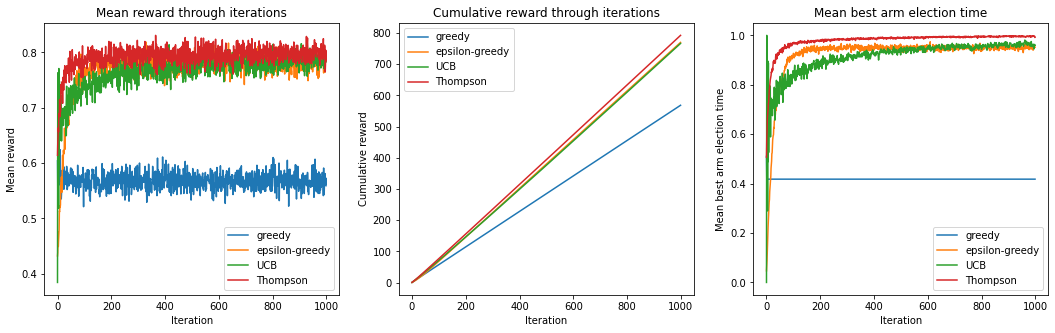

In [ ]:
init_p = [0.4 , 0.8]
epsilon = 0.1
UCB_param = 2

agents , configs = define_agents()

plot_results(agents, configs , init_p)

We can see that the mean reward is best for Thompson decision rule. Furthermore , epsilon greedy is better than UCB at first iterations but if we wait enough the mean and cumulative mean rewards with UCB become more important. 

# Question 3

First we will try to tune the hyperparameters c for UCB and $\epsilon$ for epsilon-greedy. Then we will compare the optimal configurations with thompson and greedy approaches. 

## parameter c tuning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


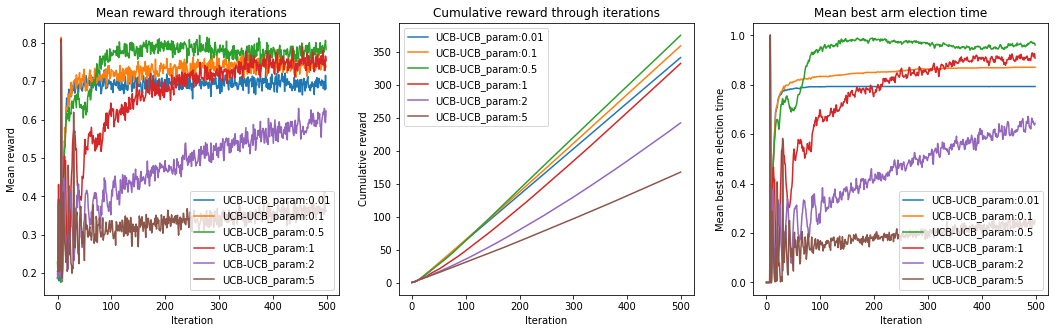

In [ ]:
hyperparameters = [0.01 , 0.1 , 0.5 , 1 , 2 , 5]
initp = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]
agents , configs = define_agents(tuning='UCB')
plot_results(agents, configs , init_p=initp, N= 500)

0.5 is the best value when using the UCB decision rule. 

When $c > 0.5 $, we encourage more exploration. This may be intersting in the first iterations but then exploiting becomes more relevant as we have better idea on the expected mean reward after each action  . <br>
When $c < 0.5 $, we encourage more exploitation. We can see on the graphs that at the beginning, models with smaller UCB parameter yield better mean reward. But in the long run , this does not give better rewards since we didn't explore enough other actions. 

## parameter $\epsilon$ tuning

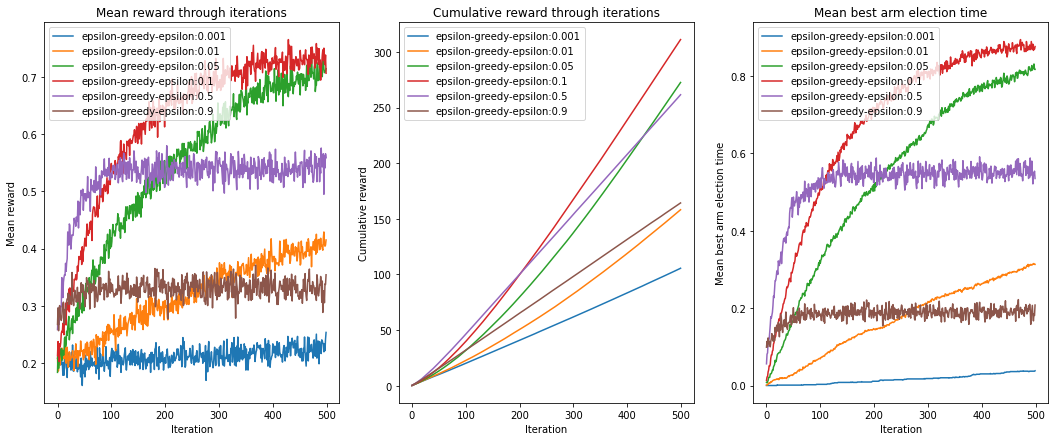

In [ ]:
hyperparameters = [0.001 , 0.01 , 0.05 , 0.1 , 0.5 , 0.9]
initp = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]
agents , configs = define_agents(tuning='epsilon-greedy')
plot_results(agents, configs , init_p=initp, N= 500)

The optimal value for $\epsilon$ is 0.1. The same interpretation of the parameter $c$ tuning for UCB can be used here , as the different values of $\epsilon$ can encourage more exploration or exploitation : for $\epsilon >0.1$, we encourage more exploration and for for $\epsilon < 0.1$ we encourage more exploitation.

# Comparison and Conclusion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


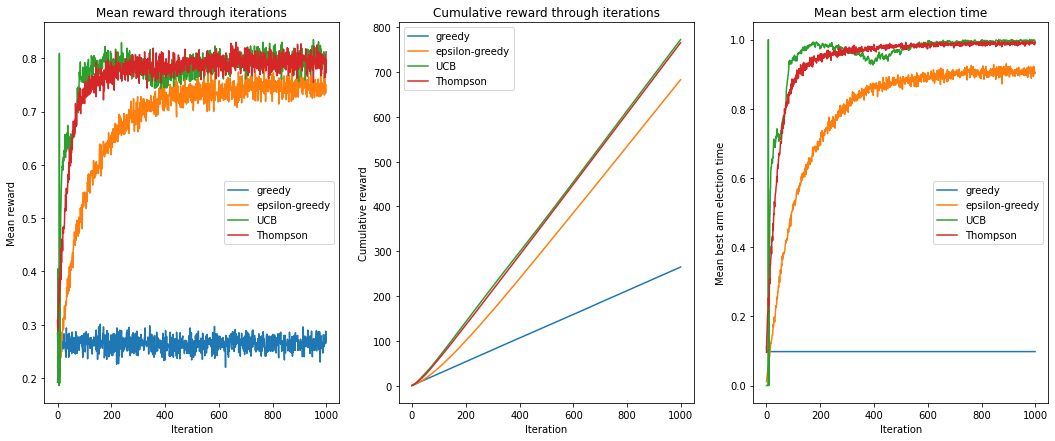

In [ ]:
initp = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]
epsilon = 0.1
UCB_param = 0.5

agents , configs = define_agents()

plot_results(agents, configs , initp , N = 1000)

After selecting the optimal hyperparameters for UCB and epsilon-greedy , we compare the different decision rules. We can observe that UCB and Thompson outperform the greedy and epsilon-greedy method. In fact , one drawback of the epsilon-greedy method is that the probability of exploration or exploitation are fixed with respect to iterations, whereas for UCB and Thompson , we can adapt this probability to explore more the unselected actions and select more the actions that give best rewards. Finally, one advantage of Thompson method on UCB is that it doesn't require a hyperparameter tuning.